In [1]:
import math

import geopandas as gpd
import numpy as np
from shapely import LineString, Polygon, Point
import shapely
from shapely import ops
import matplotlib.pyplot as plt
from CPP_Planner import CPP_Algorithms, CPP_Planner_Kit
from shapely import affinity
import warnings
warnings.filterwarnings('ignore')

In [2]:
# all_land = gpd.read_file('test_Load_Shp/shp_file/村1地_全区.shp')
all_land = gpd.read_file('test_Load_Shp/shp_file/村地和道路/村地地块区域.shp')

split_polygon_by_largest_area： 开始进行田块分割，当前误差范围 tolerance = 0.05
Num of convex_hull:  9
Num of Polygon lines:  14
Not on Convex:  6


<Axes: >

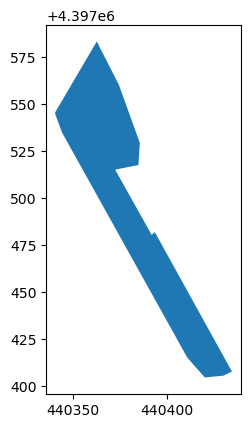

In [4]:
single_land = CPP_Planner_Kit.get_single_shp(all_land, 0)
single_polygon = single_land.geometry.iloc[0]
split_polygon = CPP_Planner_Kit.split_polygon_by_largest_area(single_polygon, tolerance=0.05)
single_land.plot()

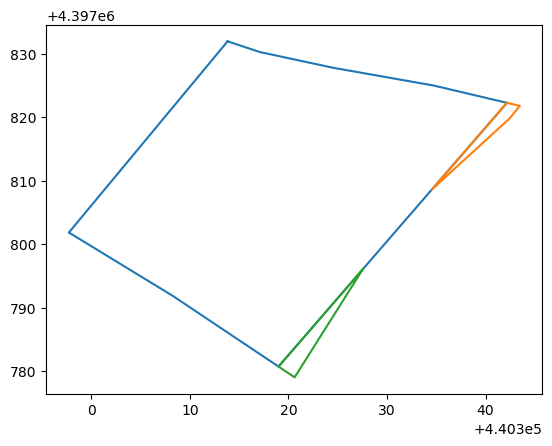

In [21]:
_, ax = plt.subplots()
for poly in split_polygon:
    ax.plot(*poly.exterior.xy)

当前田块角度： -119.14146192997518


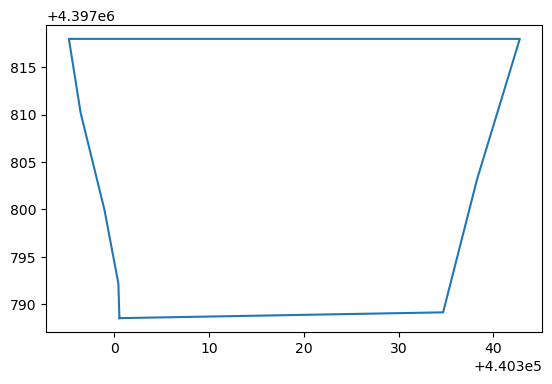

In [22]:
single_polygon: Polygon = split_polygon[0]
single_polygon_angle = CPP_Planner_Kit.get_land_MABR_angle(single_polygon)
single_polygon = affinity.rotate(single_polygon, -single_polygon_angle)
_, ax = plt.subplots()
ax.plot(*single_polygon.exterior.xy)
ax.set_aspect('equal')

## 开始测试在扫描线算法时，检测两侧地头所需的宽度，以 flat_turn 为主

left angle:  91.76326360977326
right angle 75.69150400646143
tur + vehlen / 2:  6.75
lef:  0.31246241815944836
rig:  2.5888054799417755
left:  7.062462418159448   right:  9.338805479941776
------------------------------------------------------------
left angle:  91.76326360977326
right angle 75.69150400646143
tur + vehlen / 2:  6.75
lef:  0.31246241815944836
rig:  2.5888054799417755
left:  7.062462418159448   right:  9.338805479941776
------------------------------------------------------------
left angle:  91.76326360977326
right angle 75.69150400646143
tur + vehlen / 2:  6.75
lef:  0.31246241815944836
rig:  2.5888054799417755
left:  7.062462418159448   right:  9.338805479941776
------------------------------------------------------------
left angle:  100.69816793743882
right angle 75.69150400646143
tur + vehlen / 2:  6.75
lef:  1.9175262731395524
rig:  2.5888054799417755
left:  8.667526273139552   right:  9.338805479941776
------------------------------------------------------------


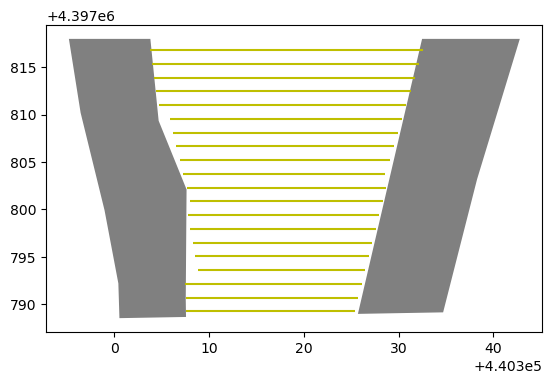

In [33]:
# square = Polygon([(0, 0), (40, 100), (160, 100), (200, 0)])
square = Polygon([(40, 0), (0, 100), (200, 100), (160, 0)])
# single_polygon = square
step_size = 1.45
headland = 'both'
turning_radius = 4.5
# vehicle_length = 6.3
vehicle_length = 4.5
land_centroid = single_polygon.centroid
def temp_scanline():
    min_x, min_y, max_x, max_y = single_polygon.bounds
    path_lines = []

    # 迭代扫描线
    for y in np.arange(min_y + step_size*0.5, max_y - step_size*0.5, step_size):
        row_points = []
        for i in range(len(single_polygon.exterior.coords) - 1):
            edge = single_polygon.exterior.coords[i]
            next_edge = single_polygon.exterior.coords[i + 1]
            if (edge[1] <= y and next_edge[1] > y) or (next_edge[1] <= y and edge[1] > y):
                x = edge[0] + (next_edge[0] - edge[0]) * (y - edge[1]) / (next_edge[1] - edge[1])
                row_points.append([x, y])
        # 创建扫描线的 LineString 对象
        if len(row_points) > 1:
            # 处理地头，首先找到 x 最小和最大的点的索引，代表当前扫描线的边界
            min_x_index = min(range(len(row_points)), key=lambda i: row_points[i][0])
            max_x_index = max(range(len(row_points)), key=lambda i: row_points[i][0])
            # 开始计算 headland_width，分为 左右 两侧各自的
            left_detector = LineString(((row_points[min_x_index][0] - 0.1, row_points[min_x_index][1]), (row_points[min_x_index][0] + 0.1, row_points[min_x_index][1])))
            right_detector = LineString(((row_points[max_x_index][0] - 0.1, row_points[max_x_index][1]), (row_points[max_x_index][0] + 0.1, row_points[max_x_index][1])))
            # # 获取两侧的相交的边
            # left_intersect_edge = left_detector.intersection(single_polygon)
            # right_intersect_edge = right_detector.intersection(single_polygon)
            # print(left_intersect_edge)

            # 计算角度，注意是和 y 轴的角度
            left_angle = -1
            right_angle = -1
            for i in range(len(single_polygon.exterior.coords) - 1):
                edge = LineString((single_polygon.exterior.coords[i], single_polygon.exterior.coords[i+1]))
                if left_detector.intersects(edge):
                    left_angle = math.atan2(edge.coords[1][1] - edge.coords[0][1],
                                            edge.coords[1][0] - edge.coords[0][0])
                    print('left angle: ', math.degrees(left_angle))
                if right_detector.intersects(edge):
                    # right_angle = math.atan2(edge.coords[1][1] - edge.coords[0][1],
                    #                         edge.coords[1][0] - edge.coords[0][0])
                    right_angle = math.atan2(edge.coords[0][1] - edge.coords[1][1], edge.coords[0][0] - edge.coords[1][0])
                    print('right angle', math.degrees(right_angle))

            # TODO: 目前这个宽度的计算有问题，不应该直接将 横跨垄距 添加到地头宽度中
            # left_headland_width = turning_radius * (1 + math.cos(1 * math.pi - left_angle)) + step_size * 7 / 2 + vehicle_length / 2
            # right_headland_width = turning_radius * (1 + math.cos(right_angle)) +  step_size * 7 / 2 + vehicle_length / 2
            # 测试，更改上面的代码
            print("tur + vehlen / 2: ", turning_radius + vehicle_length / 2)
            left_headland_width = abs(step_size * 7 * math.tan(left_angle - math.pi / 2)) + turning_radius + vehicle_length / 2
            print('lef: ', abs(step_size * 7 * math.tan(left_angle - math.pi / 2)))
            right_headland_width = abs(step_size * 7 * math.tan(right_angle - math.pi / 2)) + turning_radius + vehicle_length / 2
            print('rig: ', abs(step_size * 7 * math.tan(right_angle - math.pi / 2)))
            print("left: ", left_headland_width, "  right: ", right_headland_width)
            print('------------------------------------------------------------')

            head_land_width = 1

            if row_points[max_x_index][0] - row_points[min_x_index][0] > 10:
                # 生成地头
                if headland == 'left' or headland == 'both':
                    # row_points[min_x_index][0] = min(row_points[max_x_index][0], row_points[min_x_index][0] + left_headland_width)
                    row_points[min_x_index][0] = min(row_points[max_x_index][0], min(row_points[min_x_index][0] + left_headland_width, row_points[max_x_index][0]))
                if headland == 'right' or headland == 'both':
                    # row_points[max_x_index][0] = max(row_points[min_x_index][0], row_points[max_x_index][0] - right_headland_width)
                    row_points[max_x_index][0] = max(row_points[min_x_index][0], max(row_points[max_x_index][0] - right_headland_width, row_points[min_x_index][0]))
                path_line = LineString(row_points)
                # 尝试：仅保留固定长度以上的耕作路径?
                if path_line.length > max(left_headland_width, right_headland_width):
                    # path_line = affinity.rotate(path_line, land_angle, origin=land_centroid)
                    path_lines.append(path_line)

    # 创建 GeoDataFrame 对象
    path_gdf = gpd.GeoDataFrame(geometry=path_lines, crs=all_land.crs)
    # 生成地头区域，通过创建耕作路径的缓冲区，来找到地块的区域，最后通过差集来得到地头区域
    # print("生成地头区域...")
    path_buffer_1 = path_gdf.buffer(step_size + 0.2, single_sided=True).unary_union
    path_buffer_2 = path_gdf.buffer(-(step_size + 0.2), single_sided=True).unary_union
    path_buffer = gpd.GeoDataFrame(geometry=[path_buffer_1, path_buffer_2], crs=all_land.crs)
    path_area_union = path_buffer.unary_union
    if path_area_union != None:
        path_area_union = path_area_union.simplify(step_size * 0.8)
    # path_area_union = Polygon(path_buffer_1.union(path_buffer_2))
    headland_area = single_polygon.difference(path_area_union)
    # 由于多边形在计算机图形中本身就有误差，因此需要将一些零碎的小块删除，保留最大的作为地块即可
    if type(headland_area) == Polygon:
        headland_area = shapely.MultiPolygon([headland_area])
    # 将边缘平滑
    # if headland_area != None:
    #     headland_area = headland_area.simplify(step_size * 0.7)

    # headland_gdf = gpd.GeoDataFrame(geometry=[headland_area.convex_hull], crs=land.crs)
    headland_gdf = gpd.GeoDataFrame(geometry=[headland_area], crs=all_land.crs)
    # 保证当前的地头生成的区域仅在地块内
    headland_gdf = headland_gdf.intersection(single_polygon)
    # print("这次规划完成！")
    return path_gdf, headland_gdf

temp_path, temp_headland = temp_scanline()

_,ax = plt.subplots()
temp_path.plot(ax=ax, color='y')
temp_headland.plot(ax=ax, color='gray')
ax.set_aspect('equal')

当前田块角度： -1.403455822126613e-05


<Axes: >

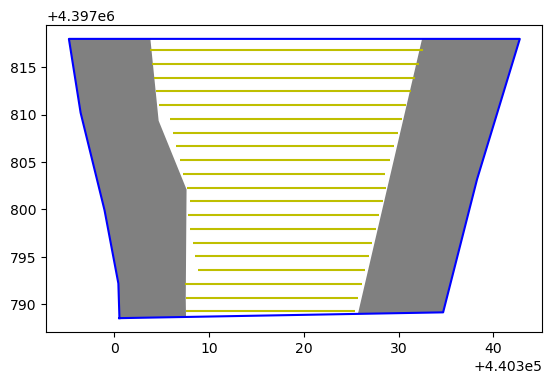

In [24]:
single_polygon_regen = gpd.GeoDataFrame(geometry=[single_polygon], crs=all_land.crs)
temp_path_2, temp_headland_2 = CPP_Algorithms.scanline_algorithm_single_with_headland_3(
    single_polygon_regen, step_size, turning_radius, vehicle_length=vehicle_length, vehicle_width=1.9,headland='both'
)
_, ax = plt.subplots()
ax.plot(*single_polygon.exterior.xy, color='b')
temp_path_2.plot(ax=ax, color='y')
temp_headland_2.plot(ax=ax, color='gray')

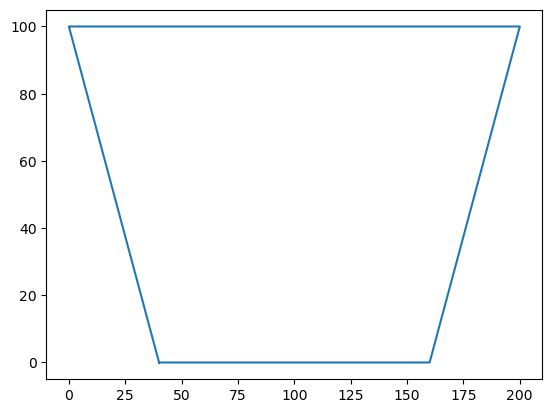

In [25]:
# 做一个标准正方形，测试一下，长200m，宽50m，Polygon
# 生成一个标准的正方形
# square = Polygon([(0, 0), (0, 200), (200, 200), (200, 0)])
fig, ax = plt.subplots()
ax.plot(*square.exterior.xy)

当前田块角度： 0.0


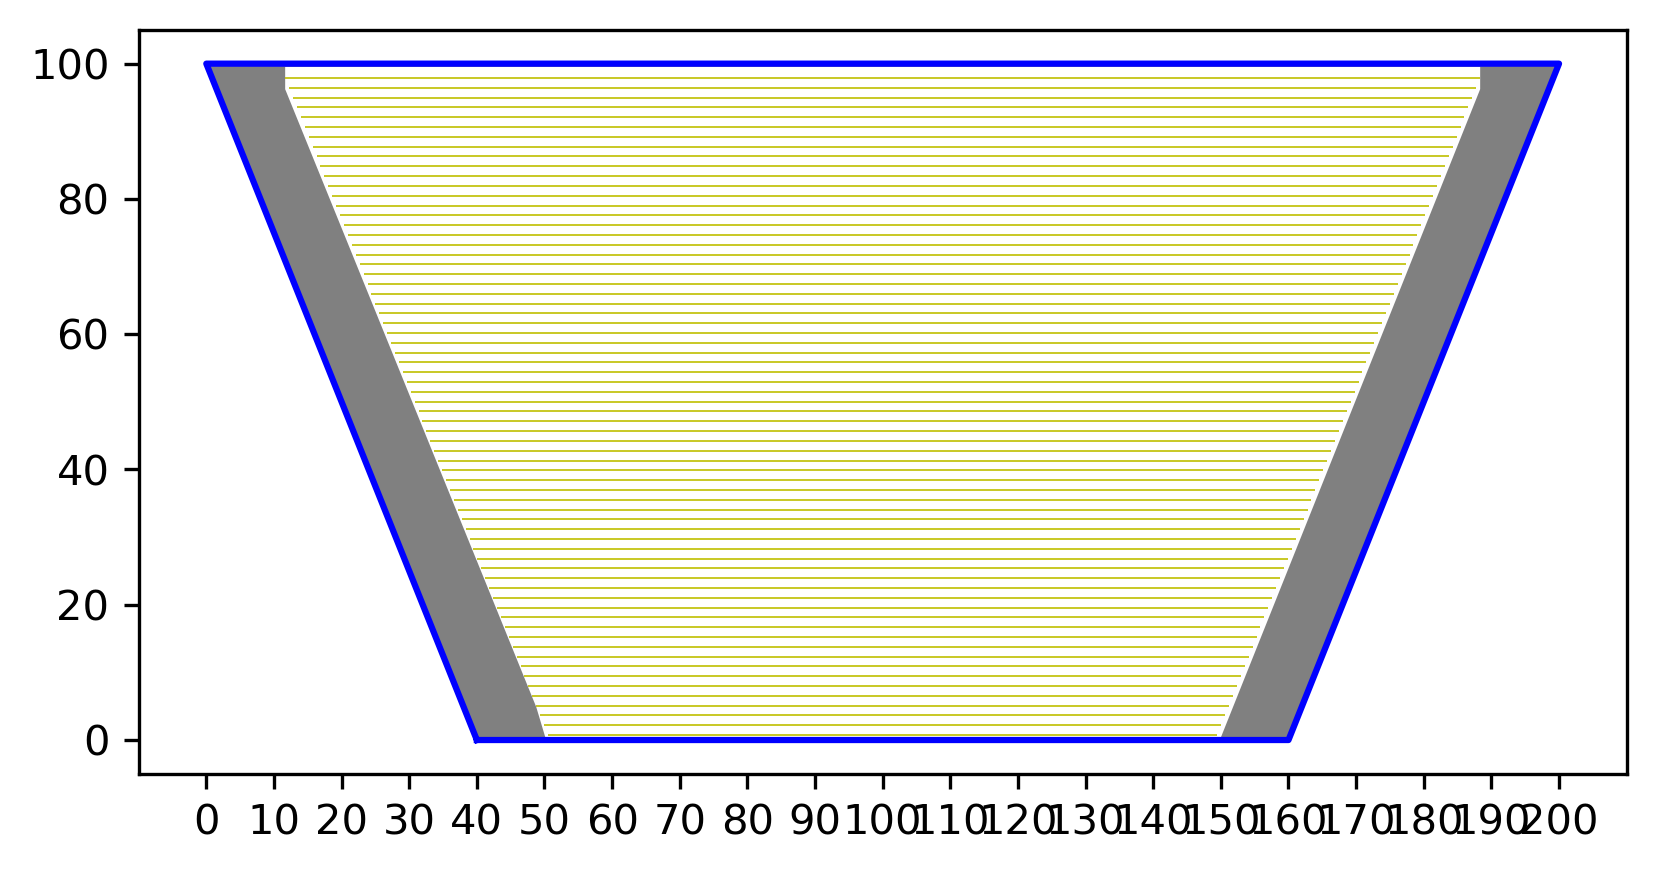

In [26]:
square_regen = gpd.GeoDataFrame(geometry=[square], crs=all_land.crs)
temp_path_3, temp_headland_3 = CPP_Algorithms.scanline_algorithm_single_with_headland_3(
    square_regen, step_size, turning_radius, vehicle_length=vehicle_length, vehicle_width=1.9,headland='both'
)
_, ax = plt.subplots(dpi=300)
# set xticks 10m
ax.set_xticks(np.arange(0, 210, 10))
ax.plot(*square.exterior.xy, color='b')
temp_path_3.plot(ax=ax, color='y', linewidth=0.4)
temp_headland_3.plot(ax=ax, color='gray')
ax.set_aspect('equal')

In [27]:
from CPP_Planner import CPP_Planner_TurningRail_Maker
# 画路径
flat_turn, fishturn = CPP_Planner_TurningRail_Maker.gen_path_flat_turn_tail_turn(temp_path, turning_radius, vehicle_length, 1.9, 1.45, land_centroid, 0)

[1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0]


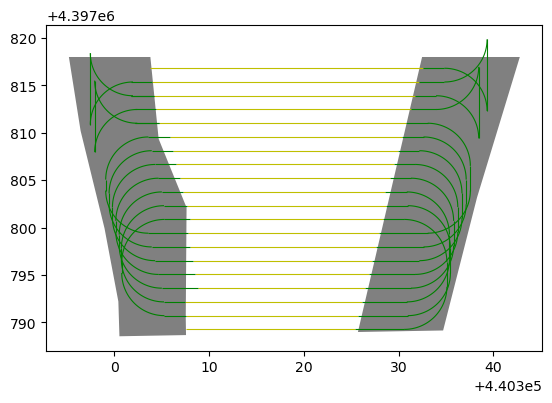

In [35]:
_,ax = plt.subplots()
temp_path.plot(ax=ax, color='y', linewidth=0.8)
temp_headland.plot(ax=ax, color='gray')
for flat in flat_turn:
    flat.plot(ax=ax, color='g', linewidth=0.8)
for fish in fishturn:
    fish.plot(ax=ax, color='g', linewidth=0.8)
ax.set_aspect('equal')